# Layout Optimization with SGD driver

In this example, a layout optimization is performed with two different gradient-based drivers: Stochastic Gradient Descent (SGD) and Sequential Least Squares Quadratic Programming (SLSQP). The purpose is to draw a comparison between the two drivers in terms of accuracy in results and computational time.

**Install TOPFARM if needed**

In [ ]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

We now import the site, wind turbine and wake models necessary to run the optimization.

In [ ]:
from py_wake.deficit_models.gaussian import BastankhahGaussian
from py_wake.examples.data.lillgrund import LillgrundSite
from py_wake.utils.gradients import autograd
from py_wake.examples.data.hornsrev1 import HornsrevV80

We also import all the TOPFARM dependencies needed for the optimization.

In [ ]:
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.easy_drivers import EasySGDDriver, EasyScipyOptimizeDriver
from topfarm.plotting import XYPlotComp
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm import TopFarmProblem
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.recorders import TopFarmListRecorder
from topfarm.constraint_components.constraint_aggregation import ConstraintAggregation
from topfarm.constraint_components.constraint_aggregation import DistanceConstraintAggregation


+------------------------------------------------------------------------------+
| pyOptSparse Error: There was an error importing the compiled snopt module    |
+------------------------------------------------------------------------------+



/Users/julianquick/miniconda3/envs/niwe2/lib/python3.11/site-packages/pyoptsparse/pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)


Then we define the site, wind farm layout and wind resource. In this example, the turbine positions are created randomly and the wind resource is represented by the sector frequency as well as the Weibull A and k parameters.

In [ ]:
# defining the site, wind turbines and wake model
site = LillgrundSite()
site.interp_method = 'linear'
windTurbines = HornsrevV80() 
wake_model = BastankhahGaussian(site, windTurbines) 

#wind farm layout
x_rows = 3 # 5 # (commented for speeding up notebook tests)
y_rows = 3 # 5
sgd_iterations = 30 # 2000
spacing = 3
xu, yu = (x_rows * spacing * windTurbines.diameter(), y_rows * spacing * windTurbines.diameter())
np.random.seed(4)
x = np.random.uniform(0, xu, x_rows * y_rows)
y = np.random.uniform(0, yu, x_rows * y_rows)
x0, y0 = (x.copy(), y.copy())
n_wt = x.size

#wind resource
dirs = np.arange(0, 360, 1) #wind directions
ws = np.arange(3, 25, 1) # wind speeds
freqs = site.local_wind(x, y, wd=dirs, ws=ws).Sector_frequency_ilk[0, :, 0]     #sector frequency
As = site.local_wind(x, y, wd=dirs, ws=ws).Weibull_A_ilk[0, :, 0]               #weibull A
ks = site.local_wind(x, y, wd=dirs, ws=ws).Weibull_k_ilk[0, :, 0]               #weibull k

/home/ernie/code/TopFarm2/.pixi/envs/py312/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:124: UserWarning: The BastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014')


The boundaries are set up as a simple rectangle enclosing the wind farm.

In [ ]:
#boundaries
boundary = np.array([(0, 0), (xu, 0), (xu, yu), (0, yu)])

Now we set up the objective function and the gradient functions needed for the optimization for both drivers. The difference relies in the wind speed and wind direction samples. For the SGD driver, the wind speed and wind direction are generated randomly and follow a Weibull distribution. On the other hand, the SLSQP driver takes a user defined array of wind speed and wind directions to study.

In [ ]:
# objective function and gradient function
samps = 50    #number of samples 

#function to create the random sampling of wind speed and wind directions
def sampling():
    idx = np.random.choice(np.arange(dirs.size), samps, p=freqs)
    wd = dirs[idx]
    A = As[idx]
    k = ks[idx]
    ws = A * np.random.weibull(k)
    return wd, ws

#aep function - SGD
def aep_func(x, y, full=False, **kwargs):
    # wd, ws = sampling()
    # aep_sgd = wake_model(x, y, wd=wd, ws=ws, time=True).aep().sum().values * 1e6
    # return aep_sgd
    return 0 # this doesn't change the performance of the driver

#gradient function - SGD
def aep_jac(x, y, **kwargs):
    wd, ws = sampling()
    jx, jy = wake_model.aep_gradients(gradient_method=autograd, wrt_arg=['x', 'y'], x=x, y=y, ws=ws, wd=wd, time=True)
    daep_sgd = np.array([np.atleast_2d(jx), np.atleast_2d(jy)]) * 1e6
    return daep_sgd

#aep function - SLSQP
def aep_func2(x, y, **kwargs):
    wd = np.arange(0, 360, 0.5)
    ws = np.arange(3, 25, 0.5)
    aep_slsqp = wake_model(x, y, wd=wd, ws=ws).aep().sum().values * 1e6
    return aep_slsqp

#gradient function - SLSQP
def aep_jac2(x, y, **kwargs):
    wd = np.arange(0, 360, 0.5)
    ws = np.arange(3, 25, 0.5)
    jx, jy = wake_model.aep_gradients(gradient_method=autograd, wrt_arg=['x', 'y'], x=x, y=y, ws=ws, wd=wd, time=False)
    daep_slsqp = np.array([np.atleast_2d(jx), np.atleast_2d(jy)]) * 1e6
    return daep_slsqp

We define the `CostModelComponent` which is responsible for evaluating the objective function and the gradients for the design variables selected.

In [ ]:
#aep component - SGD
aep_comp = CostModelComponent(input_keys=['x','y'], n_wt=n_wt, cost_function=aep_func, objective=True, cost_gradient_function=aep_jac, maximize=True)

#aep component - SLSQP
aep_comp2 = CostModelComponent(input_keys=['x','y'], n_wt=n_wt, cost_function=aep_func2, objective=True, cost_gradient_function=aep_jac2, maximize=True)

cost_comps = [aep_comp2, aep_comp]

Next we set up the constraints for the problem. The constraints for the SGD driver are defined with the `DistanceConstraintAggregation` class.

**Note**: as the class is specified, the order of the `SpacingConstraint` and `XYBoundaryConstraint` must be kept as shown in this example.

In [ ]:
min_spacing_m = 2 * windTurbines.diameter()  #minimum inter-turbine spacing in meters
constraint_comp = XYBoundaryConstraint(boundary, 'rectangle')

#constraints
constraints = [[SpacingConstraint(min_spacing_m), constraint_comp],
               DistanceConstraintAggregation(constraint_comp, n_wt, min_spacing_m, windTurbines)]

### Optimization with SGD driver

Some parameters need to be specified for the SGD driver such as max iterations, learning rate and the maximum time (in seconds). Only one optimization with a specific driver can be done at a time, which is defined by the **driver_no** variable.

In [ ]:
#driver specs
driver_names = ['SLSQP', 'SGD']
drivers = [EasyScipyOptimizeDriver(maxiter=30, tol=1e-3),
           EasySGDDriver(maxiter=sgd_iterations, learning_rate=windTurbines.diameter()/5, max_time=18000, gamma_min_factor=0.1)]

driver_no = 1    #SGD driver
ec = [10,1]      #expected cost for SLSQP (10) and SGD (1) drivers

Lastly we specify the TOPFARM problem.

In [ ]:
tf = TopFarmProblem(
        design_vars = {'x':x0, 'y':y0},         
        cost_comp = cost_comps[driver_no],    
        constraints = constraints[driver_no], 
        driver = drivers[driver_no],
        plot_comp = XYPlotComp(),
        expected_cost = ec[driver_no]
        )

INFO: checking out_of_order...
INFO:     out_of_order check complete (0.001487 sec).
INFO: checking system...
INFO:     system check complete (0.000056 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000327 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000118 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000014 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000420 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000123 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000009 sec).


INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000611 sec).
INFO: checking system...
INFO:     system check complete (0.000054 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000377 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000090 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000012 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000370 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000138 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000011 sec).


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


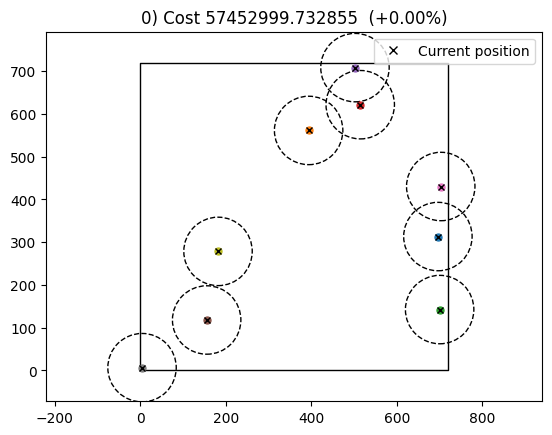

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Optimization with SGD took: 17s  with a total constraint violation of  0.001916349776975792


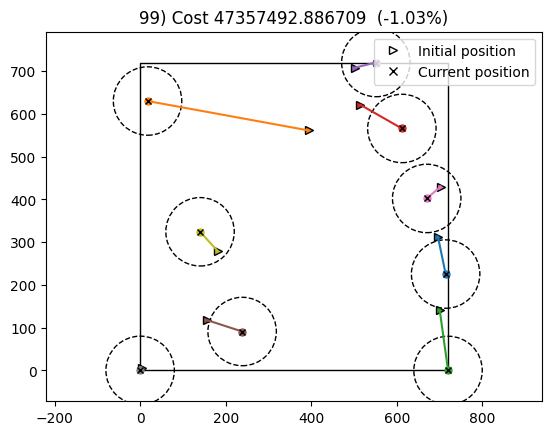

In [ ]:
tic = time.time()
cost, state, recorder = tf.optimize()
toc = time.time()
print('Optimization with SGD took: {:.0f}s'.format(toc-tic), ' with a total constraint violation of ', recorder['sgd_constraint'][-1])
recorder.save(f'{driver_names[driver_no]}')

### Optimization with SLSQP driver

INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000376 sec).
INFO: checking system...
INFO:     system check complete (0.000053 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000448 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000130 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000009 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000308 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000087 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000005 sec).
INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000467 sec).
INFO: checking system...
INFO:     system check complete (0.000059 sec).


INFO: checking solvers...
INFO:     solvers check complete (0.000379 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000109 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000009 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000319 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000078 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000005 sec).


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


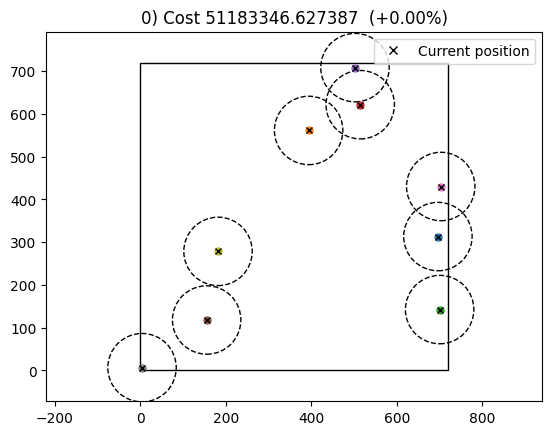

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -5576211.281413502
            Iterations: 21
            Function evaluations: 44
            Gradient evaluations: 21
Optimization Complete
-----------------------------------
Optimization with SLSQP took: 23s


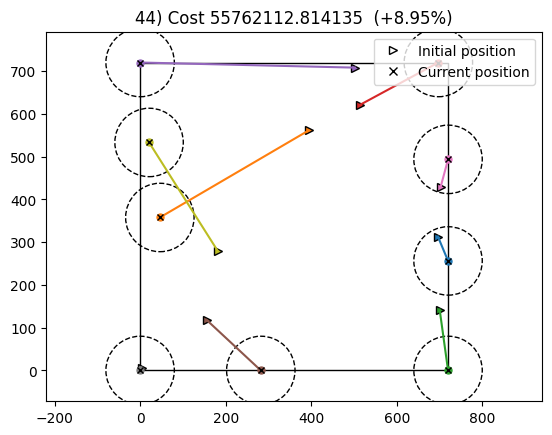

In [ ]:
driver_no = 0  # SLSQP

tf = TopFarmProblem(
    design_vars={"x": x0, "y": y0},
    cost_comp=cost_comps[driver_no],
    constraints=constraints[driver_no],
    driver=drivers[driver_no],
    plot_comp=XYPlotComp(),
    expected_cost=ec[driver_no],
)

tic = time.time()
cost, state, recorder = tf.optimize()
toc = time.time()
print("Optimization with SLSQP took: {:.0f}s".format(toc - tic))
recorder.save(f"{driver_names[driver_no]}")

### Comparison between SGD and SLSQP driver performance

When we look into the optimization time for the SGD driver, we can see how the optimization took slightly less than the maximum time chosen of 180 seconds. In the case of the SLSQP driver, it is not known how much time the optimization will take, thus being able to set up a **max_time** proves advantageous. However, for more accurate results it is recommended to increase the maximum time. 

We can also plot the AEP evolution in both cases to see the difference in terms of time and final optimized result. The AEP calculation for the SGD driver is re computed with the wind speed and wind direction distribution used for the SLSQP driver; that is, eliminating the random sampling introduced by the Monte Carlo approach.

SLSQP AEP improvement: 8.95%
SGD AEP improvement: 7.57%


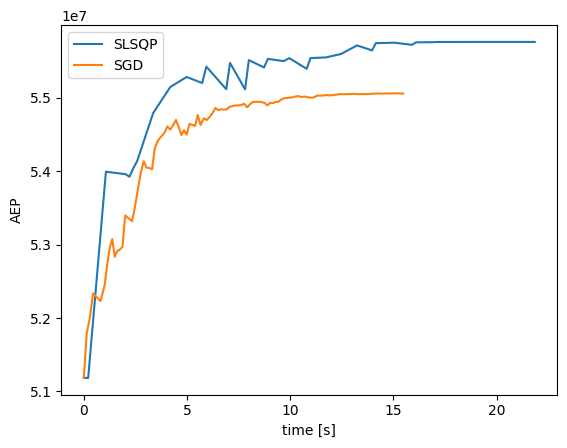

In [ ]:
plt.figure()
for i in range(2):
    rec = TopFarmListRecorder().load(f'recordings/{driver_names[i]}')
    if driver_names[i] == 'SGD':
        aep = []
        for x, y in zip(rec['x'], rec['y']):
            aep.append(aep_func2(x, y))
        print('SGD AEP improvement: {:.2f}%'.format((aep[-1] - aep[0]) / aep[0] * 100))
    else:
        aep = rec['Cost']
        print('SLSQP AEP improvement: {:.2f}%'.format((aep[-1] - aep[0]) / aep[0] * 100))
    plt.plot(rec['timestamp']-rec['timestamp'][0], aep, label=driver_names[i])
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('AEP')

### SGD Early Stopping

The SGD algorithm spends a fair amount of time treating constraint gradients as being more important than AEP gradients. The SGD algorithm can be sped up to turn off AEP computations after the learning rate has reached a specified fraction of the initial learning rate. 

INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000319 sec).
INFO: checking system...
INFO:     system check complete (0.000029 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000380 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000104 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000006 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000271 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000072 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000004 sec).
INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000263 sec).
INFO: checking system...
INFO:     system check complete (0.000035 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000281 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check com

Optimization with SGD took: 5s  with a total constraint violation of  0.0
INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000407 sec).
INFO: checking system...
INFO:     system check complete (0.000072 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000300 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000057 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000006 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000488 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000098 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000006 sec).
INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000329 sec).
INFO: checking system...
INFO:     system check complete (0.000025 sec).
INFO: checking solvers...
INFO:     solvers check complete (

Text(0, 0.5, 'AEP')

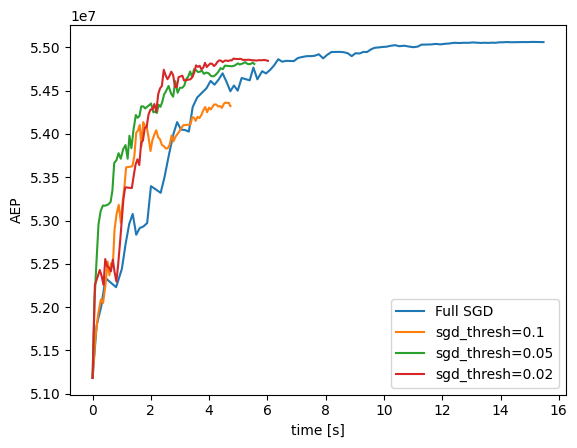

In [ ]:
plt.plot(rec['timestamp']-rec['timestamp'][0], aep, label='Full SGD')
driver_no = 1
for early in [0.1, 0.05, 0.02]:

    constraints = [[SpacingConstraint(min_spacing_m), constraint_comp],
                   DistanceConstraintAggregation(constraint_comp, n_wt, min_spacing_m, windTurbines)]
    #aep component - SGD
    aep_comp = CostModelComponent(input_keys=['x','y'], n_wt=n_wt, cost_function=aep_func, objective=True, cost_gradient_function=aep_jac, maximize=True)

    #aep component - SLSQP
    aep_comp2 = CostModelComponent(input_keys=['x','y'], n_wt=n_wt, cost_function=aep_func2, objective=True, cost_gradient_function=aep_jac2, maximize=True)

    cost_comps = [aep_comp2, aep_comp]
    
    tf = TopFarmProblem(
            design_vars = {'x':x0, 'y':y0},            
            cost_comp = cost_comps[driver_no],       
            constraints = constraints[driver_no],  
            driver = EasySGDDriver(maxiter=sgd_iterations//3,
                                   additional_constant_lr_iterations=sgd_iterations,
                                   learning_rate=windTurbines.diameter()/5, 
                                   max_time=180000, 
                                   gamma_min_factor=0.1, speedupSGD=True,
                                  sgd_thresh=early),
            plot_comp = None,
            expected_cost = ec[driver_no]
            )

    tic = time.time()
    cost, state, recorder = tf.optimize()
    toc = time.time()
    print('Optimization with SGD took: {:.0f}s'.format(toc-tic), ' with a total constraint violation of ', recorder['sgd_constraint'][-1])
    recorder.save(f'recordings/sgd_{early}')
    rec = TopFarmListRecorder().load(f'recordings/sgd_{early}')
    if recorder['sgd_constraint'][-1] > 1e-1: tag=' (invalid solution)'
    else: tag = '' 
    aep = []
    for x, y in zip(rec['x'], rec['y']):
        aep.append(aep_func2(x, y))

    plt.plot(rec['timestamp'] - rec['timestamp'][0], aep, label=f'sgd_thresh={early}' + tag)
                  
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('AEP')

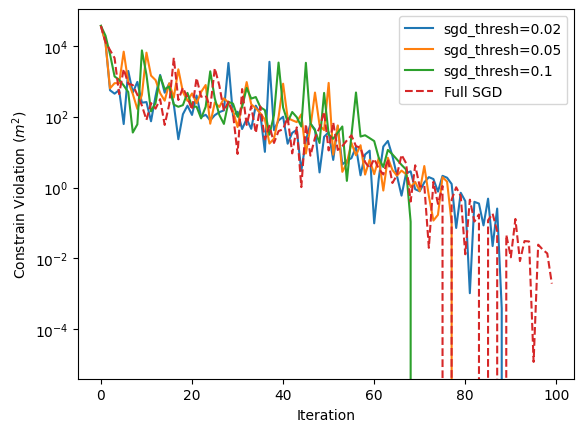

In [ ]:
# plot constraint violations
for early in np.flip([0.1, 0.05, 0.02]):
    rec = TopFarmListRecorder(f'./recordings/sgd_{early}.pkl')
    plt.plot(rec['sgd_constraint'], label=f'sgd_thresh={early}')

rec = TopFarmListRecorder(f'./recordings/SGD.pkl')
plt.plot(rec['sgd_constraint'], label=f'Full SGD', ls='--')
plt.xlabel('Iteration')
plt.ylabel("Constrain Violation $(m^2)$")
plt.yscale('log')
plt.legend()